In [31]:
import pandas as pd
import numpy as np
import os
import psycopg2
conn = psycopg2.connect(dbname='Yellow-Taxi', user='postgres', password='7466239', host='localhost', port='5432')
# Open a cursor to perform database operations
cur = conn.cursor()

In [32]:
# conn.close()

In [33]:
taxi_data_summary = pd.read_sql_query('''
select rounded_date, num_trips, day_of_week, month, hour, avg_temperature, avg_wind_speed, avg_precipitation, avg_relative_humidity, avg_visibility
from taxi_data_summary
order by 1
''', conn)

C:\Users\Mark Rozenberg\AppData\Local\Temp\ipykernel_19396\2770708493.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  taxi_data_summary = pd.read_sql_query('''


In [34]:
taxi_data_summary.shape

(17520, 10)

In [35]:
taxi_data_summary.dropna(inplace=True)
taxi_data_summary.shape

(17516, 10)

In [36]:
train = taxi_data_summary[taxi_data_summary['rounded_date'] < '2023-09-01']
test = taxi_data_summary[taxi_data_summary['rounded_date'] >= '2023-09-01']
train.set_index('rounded_date', inplace=True)
train.sort_index(inplace=True)
test.set_index('rounded_date', inplace=True)
test.sort_index(inplace=True)
print(train.shape)
print(test.shape)

(14588, 9)
(2928, 9)


In [37]:
y_train = train[['num_trips']]
x_train = train.drop(columns=['num_trips'])
y_test = test[['num_trips']]
x_test = test.drop(columns=['num_trips'])

### fitting the models

In [38]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR

In [39]:

# fitting the models
LR_Mod = LinearRegression().fit(x_train,y_train)
RFR_Mod = RandomForestRegressor().fit(x_train,y_train)
XGB_Mod = xgb.XGBRegressor().fit(x_train,y_train)
SARIMAX_Mod = SARIMAX(y_train, order = (1, 1, 1), exog=x_train).fit()
SVM_Mod = SVR().fit(x_train,y_train)

c:\Users\Mark Rozenberg\Yellow-Taxi-Climate\.venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Mark Rozenberg\Yellow-Taxi-Climate\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Mark Rozenberg\Yellow-Taxi-Climate\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Mark Rozenberg\Yellow-Taxi-Climate\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization 

In [40]:
# predicting outcome
forec_Mod1 = LR_Mod.predict(x_test)
forec_Mod2 = RFR_Mod.predict(x_test)
forec_Mod3 = XGB_Mod.predict(x_test)
forec_Mod4 = SARIMAX_Mod.predict(start=0, end=len(x_test)-1, exog=x_test)
forec_Mod4 = np.asarray(forec_Mod4)
forec_Mod5 = SVM_Mod.predict(x_test)

### LSTM - PyTorch model

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)
y_train = mm.fit_transform(y_train)
y_test = mm.fit_transform(y_test)
print('Train:', x_train.shape,y_train.shape)
print('Test:', x_test.shape,y_test.shape)

Train: (14588, 8) (14588, 1)
Test: (2928, 8) (2928, 1)


In [42]:
import torch
import torch.nn as nn
from torch.autograd import Variable
#- transform to tensors -#
x_train = Variable(torch.Tensor(x_train))
x_test = Variable(torch.Tensor(x_test))
y_train = Variable(torch.Tensor(y_train))
print('Train:', x_train.shape,y_train.shape)
print('Test:', x_test.shape,y_test.shape)

Train: torch.Size([14588, 8]) torch.Size([14588, 1])
Test: torch.Size([2928, 8]) (2928, 1)


In [43]:
# reshaping to rows, timestamps, features
x_train = torch.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = torch.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print('Train:', x_train.shape,y_train.shape)
print('Test:', x_test.shape,y_test.shape)

Train: torch.Size([14588, 1, 8]) torch.Size([14588, 1])
Test: torch.Size([2928, 1, 8]) (2928, 1)


In [44]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [45]:
num_epochs = 1000
learning_rate = 0.001
input_size = 8 #number of features
hidden_size = 40 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train.shape[1]) #our lstm class
criterion = torch.nn.MSELoss()    # Criterion of minimization (mean-squared error)
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [46]:
# training
for epoch in range(num_epochs):
  outputs = lstm1.forward(x_train) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
  # obtain the loss function
  loss = criterion(outputs, y_train)
  loss.backward() #calculates the loss of the loss function
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.26976
Epoch: 100, loss: 0.02572
Epoch: 200, loss: 0.01446
Epoch: 300, loss: 0.00924
Epoch: 400, loss: 0.00507
Epoch: 500, loss: 0.00405
Epoch: 600, loss: 0.00364
Epoch: 700, loss: 0.00342
Epoch: 800, loss: 0.00323
Epoch: 900, loss: 0.00311


In [47]:
# prediction
train_predict = lstm1(x_test) #forward pass
forec_Mod6 = train_predict.data.numpy() #numpy conversion
forec_Mod6 = mm.inverse_transform(forec_Mod6) #reverse transformation
y_test = mm.inverse_transform(y_test) #reverse transformation of y_test for comparison

### models accuracy comparison

In [48]:
# calculate prediction metrics
Compare_Table = pd.DataFrame(columns=['Model','MAE','MSE','EVS','COD'])
ModList = ['LR','RFR','XGB','SARIMAX','SVM','LSTM']
ForecList = [forec_Mod1,forec_Mod2,forec_Mod3,forec_Mod4,forec_Mod5,forec_Mod6]
for x in range(0,6):
    mod = ForecList[x]
    ModDesc = ModList[x]
    new_row = pd.DataFrame({'Model': [ModDesc],
                            'MAE': [mean_absolute_error(y_test, mod)],
                            'MSE': [mean_squared_error(y_test, mod)],
                            'EVS': [explained_variance_score(y_test, mod)],
                            'COD': [r2_score(y_test, mod)]})
    Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)

C:\Users\Mark Rozenberg\AppData\Local\Temp\ipykernel_19396\4213566647.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)


In [49]:
Compare_Table = Compare_Table.sort_values(by='MAE', ascending=True)
Compare_Table

,Model,MAE,MSE,EVS,COD
1,RFR,733.486800,1.540537e+06,0.789229,0.786719
2,XGB,778.543389,1.519502e+06,0.790751,0.789631
5,LSTM,864.798915,1.755872e+06,0.758158,0.756907
3,SARIMAX,1260.558919,3.060335e+06,0.577099,0.576309
0,LR,1625.427521,3.853980e+06,0.466907,0.466432
4,SVM,2159.642823,6.665819e+06,0.115075,0.077145


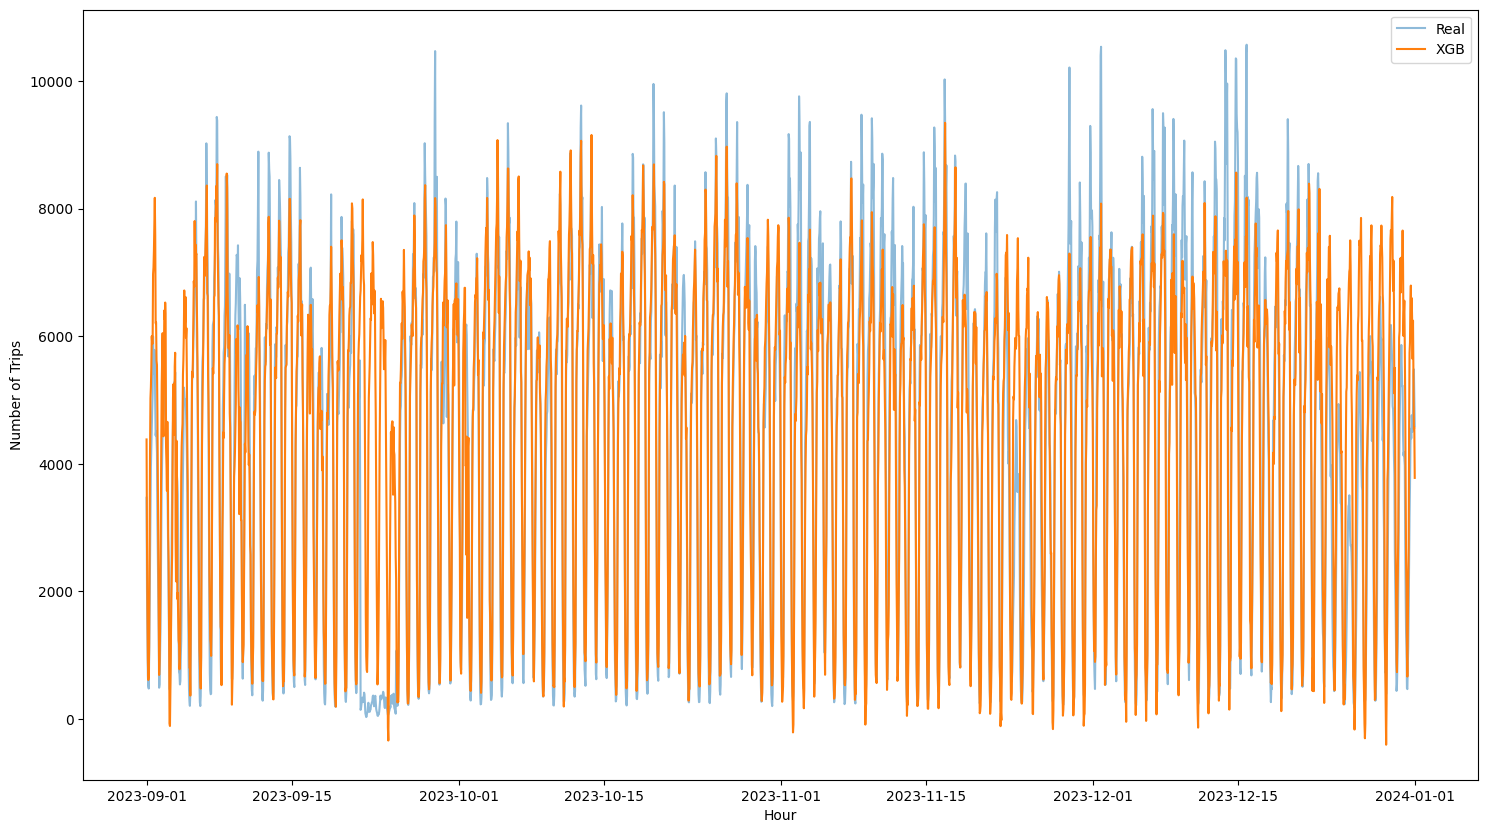

In [51]:
import matplotlib.pyplot as plt
# graphics
plt.figure(figsize=(18, 10))
y_test = y_test[np.argsort(test.index)]
plt.plot(test.index, y_test, label='Real', alpha=0.5)
# plt.plot(test.index, forec_Mod1, label='LR')
# plt.plot(test.index, forec_Mod2, label='RFR')
plt.plot(test.index, forec_Mod3, label='XGB')
# plt.plot(test.index, forec_Mod4, label='SARIMAX')
# plt.plot(test.index, forec_Mod5, label='SVM')
# plt.plot(test.index, forec_Mod6, label='LSTM', alpha=0.5)
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.legend()

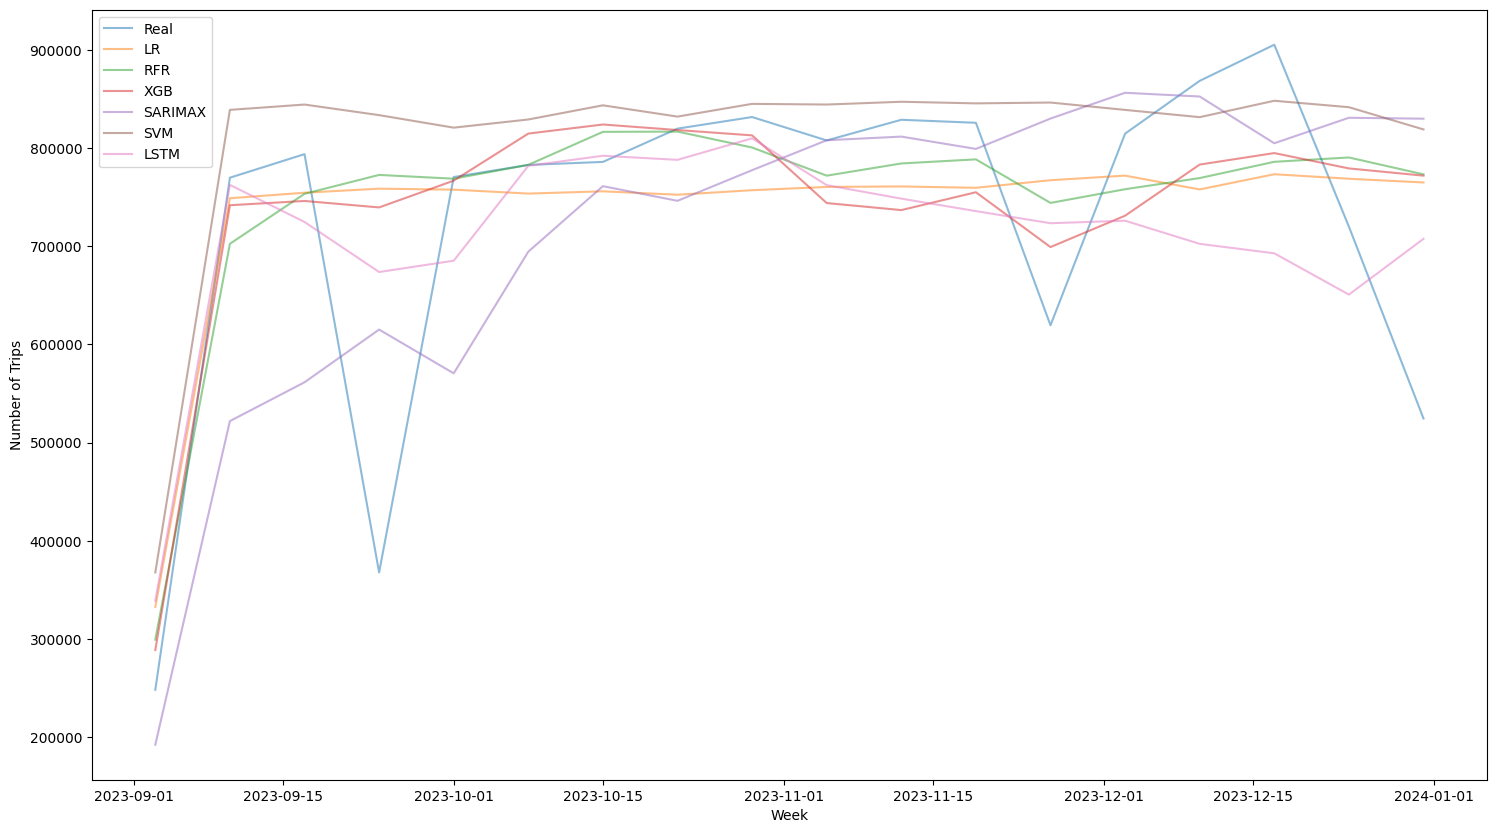

In [55]:
# Convert y_test and forec_Mod6 to DataFrames with datetime index
y_test_df = pd.DataFrame(y_test, index=test.index, columns=['num_trips'])
forec_Mod1_df = pd.DataFrame(forec_Mod1, index=test.index, columns=['num_trips'])
forec_Mod2_df = pd.DataFrame(forec_Mod2, index=test.index, columns=['num_trips'])
forec_Mod3_df = pd.DataFrame(forec_Mod3, index=test.index, columns=['num_trips'])
forec_Mod4_df = pd.DataFrame(forec_Mod4, index=test.index, columns=['num_trips'])
forec_Mod5_df = pd.DataFrame(forec_Mod5, index=test.index, columns=['num_trips'])
forec_Mod6_df = pd.DataFrame(forec_Mod6, index=test.index, columns=['num_trips'])

# Sum y_test and forec_Mod6 weekly
y_test_weekly_sum = y_test_df.resample('W').sum()
forec_Mod1_weekly_sum = forec_Mod1_df.resample('W').sum()
forec_Mod2_weekly_sum = forec_Mod2_df.resample('W').sum()
forec_Mod3_weekly_sum = forec_Mod3_df.resample('W').sum()
forec_Mod4_weekly_sum = forec_Mod4_df.resample('W').sum()
forec_Mod5_weekly_sum = forec_Mod5_df.resample('W').sum()
forec_Mod6_weekly_sum = forec_Mod6_df.resample('W').sum()

# Plot the results
plt.figure(figsize=(18, 10))
plt.plot(y_test_weekly_sum.index, y_test_weekly_sum['num_trips'], label='Real', alpha=0.5)
plt.plot(forec_Mod1_weekly_sum.index, forec_Mod1_weekly_sum['num_trips'], label='LR', alpha=0.5)
plt.plot(forec_Mod2_weekly_sum.index, forec_Mod2_weekly_sum['num_trips'], label='RFR', alpha=0.5)
plt.plot(forec_Mod3_weekly_sum.index, forec_Mod3_weekly_sum['num_trips'], label='XGB', alpha=0.5)
plt.plot(forec_Mod4_weekly_sum.index, forec_Mod4_weekly_sum['num_trips'], label='SARIMAX', alpha=0.5)
plt.plot(forec_Mod5_weekly_sum.index, forec_Mod5_weekly_sum['num_trips'], label='SVM', alpha=0.5)
plt.plot(forec_Mod6_weekly_sum.index, forec_Mod6_weekly_sum['num_trips'], label='LSTM', alpha=0.5)
plt.xlabel('Week')
plt.ylabel('Number of Trips')
plt.legend()
plt.show()